[✓] Project Root: C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection
[✓] Loaded train=(125973, 43), test=(22544, 42)
[✓] Schema Locked: 41 features.
[✓] Split Sizes: Train=88181 (70%) | ES=18896 (15%) | Thr=18896 (15%)

[1] Training Binary XGBoost (Gen-Optimized)...
    scale_pos_weight: 1.72
    [✓] Trained (Best Iteration: 3487)

[2] Threshold Tuning on THR (RAW probs, PosRate band)...
[✓] Selected Threshold: 0.0011 [Optimized (PosRate 0.55-0.75)]
    THR@best -> F2=0.9647 | P=0.8453 | R=1.0000 | PosRate=0.551
    THR prob quantiles (1/10/50/90/99): [1.77488474e-06 7.66021685e-06 5.02621150e-03 9.99999404e-01
 9.99999881e-01]

🔎 PORTABILITY CHECK (RAW):
    THR Set: {'Precision': 0.8453330769970201, 'Recall': 1.0, 'PosRate': 0.5505397967823878}
    TEST:    {'Precision': 0.8813917864176818, 'Recall': 0.941556923556456, 'PosRate': 0.6080997161107168}
    mean(test_probs)=0.3799  (diagnostic only)

--- Classification Report (TEST) ---
              precision    

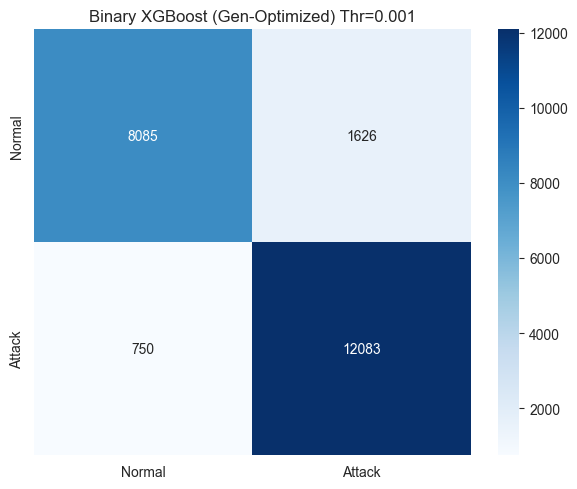

ROC-AUC: 0.9545
PR-AUC:  0.9515

[3] Training Multi-class Model (Attacks Only)...

=== Multi-class TEST Results (Attacks Only) ===
              precision    recall  f1-score   support

         DoS     0.9741    0.8634    0.9154      7460
       Probe     0.5216    0.9318    0.6688      2421
         R2L     0.9710    0.6031    0.7441      2885
         U2R     0.3750    0.5821    0.4561        67

    accuracy                         0.8163     12833
   macro avg     0.7104    0.7451    0.6961     12833
weighted avg     0.8849    0.8163    0.8280     12833


[4] Saving Artifacts...
[✓] Saved successfully.


In [21]:
# ==============================================================================
# 03_model_training.ipynb — NSL-KDD (Best-Recall Robust Edition, NO leakage)
# ==============================================================================
# GOAL:
# - Improve TEST Attack Recall without collapsing Precision / overall performance.
#
# CHANGES (based on your latest results):
# 1) REMOVE unlabeled logit-shift correction (it pushed the wrong way here).
#    Reason: mean(test_proba) << true test attack rate => not pure label-shift.
# 2) Keep best-iteration-safe predict_proba (iteration_range) ✅
# 3) Threshold tuning on THR-set (ONLY) using RAW probs:
#    - Max F2 within a "less conservative" PosRate band (0.55–0.75)
#    - Optional: if no candidate, fallback to classic Max F2 (no constraints)
# 4) Stronger generalization hyperparams (shallower + more reg + more sampling noise)
#    to transfer better to KDDTest+ shift.
# ==============================================================================

import os, json, time, copy, joblib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["savefig.dpi"] = 300

RANDOM_STATE = 42

# ------------------------------------------------------------------------------
# 1) Paths & Setup
# ------------------------------------------------------------------------------
def get_project_root() -> Path:
    cwd = Path.cwd().resolve()
    return cwd.parent if cwd.name == "notebooks" else cwd

PROJECT_ROOT = get_project_root()
DATA_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
MODELS_DIR = RESULTS_DIR / "models"
FIGURES_DIR = RESULTS_DIR / "figures"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"[✓] Project Root: {PROJECT_ROOT}")

# ------------------------------------------------------------------------------
# 2) Load Data
# ------------------------------------------------------------------------------
train_path = DATA_DIR / "train_cleaned.csv"
test_path  = DATA_DIR / "test_cleaned.csv"
if not train_path.exists():
    raise FileNotFoundError("Run 01/02 notebooks first.")

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print(f"[✓] Loaded train={train_df.shape}, test={test_df.shape}")

# ------------------------------------------------------------------------------
# 3) Label Mapping
# ------------------------------------------------------------------------------
LABEL_COL = "label"

attack_mapping = {
    'normal': 'Normal',
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS', 'worm': 'DoS',
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L',
    'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L',
    'snmpguess': 'R2L', 'snmpgetattack': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'ps': 'U2R',
    'sqlattack': 'U2R', 'xterm': 'U2R'
}

def map_labels(series: pd.Series) -> pd.Series:
    return series.astype(str).str.lower().str.strip().map(attack_mapping).fillna("Normal")

train_df["attack_class"] = map_labels(train_df[LABEL_COL])
test_df["attack_class"]  = map_labels(test_df[LABEL_COL])

train_df["binary_target"] = (train_df["attack_class"] != "Normal").astype(int)
test_df["binary_target"]  = (test_df["attack_class"]  != "Normal").astype(int)

# ------------------------------------------------------------------------------
# 4) Feature Preparation (Locked Schema)
# ------------------------------------------------------------------------------
DROP_COLS = [LABEL_COL, "attack_class", "binary_target", "attack_category", "level", "id"]

X_train_full = train_df.drop(columns=DROP_COLS, errors="ignore")
X_test_full  = test_df.drop(columns=DROP_COLS, errors="ignore")

FEATURE_COLUMNS = sorted(set(X_train_full.columns).union(set(X_test_full.columns)))
X_train_full = X_train_full.reindex(columns=FEATURE_COLUMNS, fill_value=0)
X_test_full  = X_test_full.reindex(columns=FEATURE_COLUMNS, fill_value=0)

y_train_bin = train_df["binary_target"].values
y_test_bin  = test_df["binary_target"].values

print(f"[✓] Schema Locked: {len(FEATURE_COLUMNS)} features.")

# ------------------------------------------------------------------------------
# 5) Preprocessing Pipeline
# ------------------------------------------------------------------------------
CAT_COLS = [c for c in ["protocol_type", "service", "flag"] if c in FEATURE_COLUMNS]
NUM_COLS = [c for c in FEATURE_COLUMNS if c not in CAT_COLS]
LOG_COLS = ["src_bytes", "dst_bytes", "duration", "hot", "num_compromised"]

def safe_log1p(df: pd.DataFrame) -> pd.DataFrame:
    df_out = df.copy()
    for c in LOG_COLS:
        if c in df_out.columns:
            df_out[c] = np.log1p(pd.to_numeric(df_out[c], errors="coerce").fillna(0).clip(lower=0))
    return df_out

num_pipeline = Pipeline([
    ("log_transform", FunctionTransformer(safe_log1p, feature_names_out="one-to-one")),
    ("scaler", RobustScaler())
])

cat_pipeline = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

base_preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, NUM_COLS),
        ("cat", cat_pipeline, CAT_COLS)
    ],
    remainder="drop"
)

# ------------------------------------------------------------------------------
# 6) Split (70/15/15)
# ------------------------------------------------------------------------------
X_tr_raw, X_tmp, y_tr, y_tmp = train_test_split(
    X_train_full, y_train_bin, test_size=0.30, stratify=y_train_bin, random_state=RANDOM_STATE
)
X_es_raw, X_thr_raw, y_es, y_thr = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=RANDOM_STATE
)

print(f"[✓] Split Sizes: Train={len(X_tr_raw)} (70%) | ES={len(X_es_raw)} (15%) | Thr={len(X_thr_raw)} (15%)")

# ------------------------------------------------------------------------------
# 7) Train Binary XGBoost (Generalization-optimized)
# ------------------------------------------------------------------------------
print("\n[1] Training Binary XGBoost (Gen-Optimized)...")

preprocessor_bin = copy.deepcopy(base_preprocessor)
X_tr_enc = preprocessor_bin.fit_transform(X_tr_raw)
X_es_enc = preprocessor_bin.transform(X_es_raw)

neg, pos = np.bincount(y_tr)

# Slightly stronger recall push (but still mild)
scale_pos_weight = (neg / pos) * 1.5
print(f"    scale_pos_weight: {scale_pos_weight:.2f}")

xgb_bin = XGBClassifier(
    n_estimators=7000,
    learning_rate=0.02,
    max_depth=3,
    min_child_weight=10,

    subsample=0.8,          # was 0.7
    colsample_bytree=0.8,   # was 0.7
    gamma=0.15,             # was 0.2
    reg_lambda=5.0,         # was 6.0

    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    early_stopping_rounds=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
)

xgb_bin.fit(
    X_tr_enc, y_tr,
    eval_set=[(X_es_enc, y_es)],
    verbose=False
)

print(f"    [✓] Trained (Best Iteration: {xgb_bin.best_iteration})")

final_binary_pipeline = Pipeline([
    ("prep", preprocessor_bin),
    ("model", xgb_bin)
])

# ------------------------------------------------------------------------------
# 7.1) Best-iteration-safe predict_proba (CRITICAL)
# ------------------------------------------------------------------------------
def predict_proba_best_iter(pipe: Pipeline, X_raw: pd.DataFrame) -> np.ndarray:
    prep = pipe.named_steps["prep"]
    model = pipe.named_steps["model"]
    X_enc = prep.transform(X_raw)
    best = getattr(model, "best_iteration", None)
    if best is None:
        return model.predict_proba(X_enc)[:, 1]
    return model.predict_proba(X_enc, iteration_range=(0, best + 1))[:, 1]

# ------------------------------------------------------------------------------
# 8) Threshold Tuning on THR (RAW probs)
#    Strategy: Max F2 within PosRate band (0.55–0.75) to avoid being too conservative.
# ------------------------------------------------------------------------------
print("\n[2] Threshold Tuning on THR (RAW probs, PosRate band)...")

probs_thr = predict_proba_best_iter(final_binary_pipeline, X_thr_raw)

thresholds = np.linspace(1e-4, 1 - 1e-4, 2001)

beta = 2.0
f2_scores = []
precisions = []
recalls = []
pos_rates = []

for thr in thresholds:
    preds = (probs_thr >= thr).astype(int)
    p = precision_score(y_thr, preds, zero_division=0)
    r = recall_score(y_thr, preds, zero_division=0)
    pr = preds.mean()
    f2 = (1 + beta**2) * (p * r) / ((beta**2 * p) + r + 1e-12)

    f2_scores.append(f2)
    precisions.append(p)
    recalls.append(r)
    pos_rates.append(pr)

f2_scores = np.nan_to_num(np.array(f2_scores), nan=-1.0)
precisions = np.array(precisions)
recalls = np.array(recalls)
pos_rates = np.array(pos_rates)

# PosRate band chosen to push a less conservative operating point (helps TEST recall)
LOW_PR, HIGH_PR = 0.55, 0.75   #was 0.50, 0.75
mask = (pos_rates >= LOW_PR) & (pos_rates <= HIGH_PR)

# add guardrail:
q10 = np.quantile(probs_thr, 0.10)
thr_floor = max(1e-4, q10 * 0.25)
mask = mask & (thresholds >= thr_floor)

if np.any(mask):
    best_idx = int(np.argmax(np.where(mask, f2_scores, -1.0)))
    status = f"Optimized (PosRate {LOW_PR:.2f}-{HIGH_PR:.2f})"
else:
    best_idx = int(np.argmax(f2_scores))
    status = "Fallback (Pure F2)"

best_thr = float(thresholds[best_idx])

print(f"[✓] Selected Threshold: {best_thr:.4f} [{status}]")
print(f"    THR@best -> F2={f2_scores[best_idx]:.4f} | P={precisions[best_idx]:.4f} | R={recalls[best_idx]:.4f} | PosRate={pos_rates[best_idx]:.3f}")
print(f"    THR prob quantiles (1/10/50/90/99): {np.quantile(probs_thr, [0.01,0.1,0.5,0.9,0.99])}")

# ------------------------------------------------------------------------------
# 9) TEST Evaluation + Portability Check (RAW)
# ------------------------------------------------------------------------------
print("\n🔎 PORTABILITY CHECK (RAW):")

def eval_at(th, y_true, y_proba):
    y_hat = (y_proba >= th).astype(int)
    return {
        "Precision": float(precision_score(y_true, y_hat, zero_division=0)),
        "Recall":    float(recall_score(y_true, y_hat, zero_division=0)),
        "PosRate":   float(y_hat.mean())
    }

test_probs = predict_proba_best_iter(final_binary_pipeline, X_test_full)

print(f"    THR Set: {eval_at(best_thr, y_thr, probs_thr)}")
print(f"    TEST:    {eval_at(best_thr, y_test_bin, test_probs)}")
print(f"    mean(test_probs)={test_probs.mean():.4f}  (diagnostic only)")

print("\n--- Classification Report (TEST) ---")
test_preds = (test_probs >= best_thr).astype(int)
print(classification_report(y_test_bin, test_preds, target_names=["Normal", "Attack"], digits=4))

cm = confusion_matrix(y_test_bin, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title(f"Binary XGBoost (Gen-Optimized) Thr={best_thr:.3f}")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "cm_binary.png")
plt.show()

print(f"ROC-AUC: {roc_auc_score(y_test_bin, test_probs):.4f}")
print(f"PR-AUC:  {average_precision_score(y_test_bin, test_probs):.4f}")

# ------------------------------------------------------------------------------
# 10) Multi-class Model (Attack-Only) — keep as-is (your current is fine)
# ------------------------------------------------------------------------------
print("\n[3] Training Multi-class Model (Attacks Only)...")

train_attacks = train_df[train_df["attack_class"] != "Normal"]
test_attacks  = test_df[test_df["attack_class"] != "Normal"]

X_train_multi = X_train_full.loc[train_attacks.index]
y_train_multi = train_attacks["attack_class"]
X_test_multi  = X_test_full.loc[test_attacks.index]
y_test_multi  = test_attacks["attack_class"]

multi_le = LabelEncoder()
y_train_enc = multi_le.fit_transform(y_train_multi)
y_test_enc  = multi_le.transform(y_test_multi)

prep_multi = copy.deepcopy(base_preprocessor)
xgb_multi = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

final_multi_pipeline = Pipeline([
    ("prep", prep_multi),
    ("model", xgb_multi)
])

classes = np.unique(y_train_enc)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_enc)
weight_dict = dict(zip(classes, weights))
sample_weights = [weight_dict[y] for y in y_train_enc]

final_multi_pipeline.fit(X_train_multi, y_train_enc, model__sample_weight=sample_weights)

multi_preds = final_multi_pipeline.predict(X_test_multi)
print("\n=== Multi-class TEST Results (Attacks Only) ===")
print(classification_report(y_test_enc, multi_preds, target_names=multi_le.classes_, digits=4))

# ------------------------------------------------------------------------------
# 11) Save Artifacts
# ------------------------------------------------------------------------------
print("\n[4] Saving Artifacts...")

joblib.dump(final_binary_pipeline, MODELS_DIR / "binary_model.pkl")
joblib.dump(final_multi_pipeline,  MODELS_DIR / "multi_model.pkl")
joblib.dump(multi_le,              MODELS_DIR / "multi_label_encoder.pkl")

metadata = {
    "feature_columns": FEATURE_COLUMNS,
    "binary_threshold": float(best_thr),
    "threshold_strategy": {
        "type": "MaxF2_with_PosRateBand",
        "beta": 2.0,
        "posrate_band": [LOW_PR, HIGH_PR]
    },
    "binary_model_best_iteration": int(final_binary_pipeline.named_steps["model"].best_iteration),
    "generated_at": time.strftime("%Y-%m-%d %H:%M:%S")
}

with open(MODELS_DIR / "model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("[✓] Saved successfully.")
